# Проект. Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
!pip install catboost
import numpy as np
from catboost import Pool, CatBoostRegressor

In [2]:
!pip install lightgbm
import lightgbm as lgb

In [3]:
!pip install xgboost
import xgboost as xgb

In [4]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [5]:
full = pd.read_csv('autos.csv', sep=',' , decimal='.')
full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
full.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [7]:
# Удалим ненужные признаки 
full = full.drop(['DateCrawled','RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1).copy()

In [8]:
# Удалим необоснованный (на мой взгляд) строки с ценами меньшими 100, посчитав их некорректными. Это примерно 4% от всех данных
full_1 = full[(full['Price'] >= 100)].copy()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002412ECE2520>]],
      dtype=object)

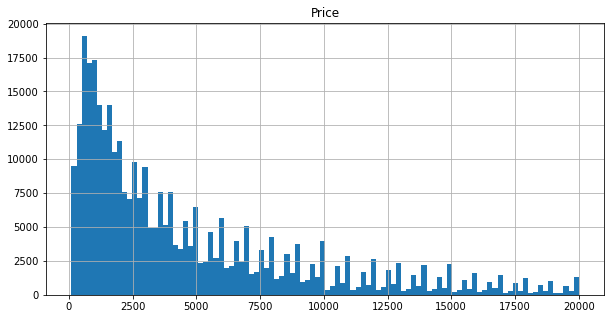

In [9]:
# Распределение цен
full_1.hist(column='Price', bins=100, figsize = (10,5))

In [10]:
# Заменим NaN в столбце VehicleType на значение 'unknown'. Всего таких замен 32612
full_1['VehicleType'] = full_1['VehicleType'].fillna('unknown')

In [11]:
# Удалим строки с датой выпуска за пределами отрезка 1900-2019. Остальные года считаем некорректными
full_2 = full_1.query('RegistrationYear >= 1900 and RegistrationYear <= 2019').copy()

In [12]:
# Заменим NaN в столбце на значение 'unknown'. Всего таких замен 16314
full_2['Gearbox'] = full_2['Gearbox'].fillna('unknown')

In [13]:
# Удалим строки с некорректной мощностью, менее 20 и более 1000 л.с.
full_3 = full_2.query('Power <= 1000 and Power > 20').copy()
# Альтернатива  - заполнение медианными значениями нулевых значений, но это менее корректно
# full_2['Power'] = full_2['Power'].replace(0,full_2['Power'].median())

In [14]:
# Заменим NaN в столбце 'Model'на значение 'unknown'. Всего таких замен 12112
full_3['Model'] = full_3['Model'].fillna('unknown')

In [15]:
# Заменим NaN в столбце 'FuelType'на значение 'unknown'. Всего таких замен 19444
full_3['FuelType'] = full_3['FuelType'].fillna('unknown')

In [16]:
# Заменим NaN в столбце 'NotRepaired'на значение 'unknown'. Всего таких замен 46497
full_3['NotRepaired'] = full_3['NotRepaired'].fillna('unknown')

In [17]:
# Удалим строки, где количество неизвестных показателей 'unknown' более 2. Всего 6970 строк
full_3['num_unique'] = full_3.nunique(axis=1)
full_4 = full_3.loc[full_3['num_unique'] >8]
fill_min = full_4.drop(['num_unique'], axis=1).copy()

In [18]:
# Определение датафрейма для построения модели
df = fill_min.reset_index(drop=True)

# 2. Обучение моделей

In [19]:
# Разбиение на тестовую и валидационную выборки
train, test = train_test_split(df, test_size=0.3, random_state=42)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
X_train = train.drop(['Price'], axis=1)
y_train = train['Price']
X_test = test.drop(['Price'], axis=1)
y_test = test['Price']

In [20]:
# Масштабируем признаки, чтобы не было большого разброса по столбцам
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

## 2.1 CatBoost 

In [21]:
# Подор параметров
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
model = CatBoostRegressor(eval_metric='RMSE', cat_features = cat_features, silent=True)
parameters = {'depth'         : [6,8,10],
             'learning_rate' : [0.01, 0.05, 0.1],
             'iterations'    : [30, 50, 100]
              }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3)
grid.fit(X_train, y_train)

print("\n Наилучший результат:\n", grid.best_score_)
print("\n Наилучшие параметры:\n", grid.best_params_)


 Наилучший результат:
 0.867982882867867

 Наилучшие параметры:
 {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}


In [22]:
# Обучение и оценка модели
t1 = time.time()
cbr = CatBoostRegressor(eval_metric='RMSE', depth = 10, iterations = 100, learning_rate = 0.1, silent=True)
cbr.fit(X_train, y_train, cat_features = cat_features) 
t2 = time.time()
t_cbr = t2 - t1
print('Время выполнения:', t_cbr)
pred = cbr.predict(X_test)
t3 = time.time()
t_cbr_pred = t3-t2
print('Время предсказания:', t_cbr_pred)
mse = mean_squared_error(y_test, pred)
rmse_cbr = mse ** 0.5
print("RMSE:", rmse_cbr)

Время выполнения: 13.036489009857178
Время предсказания: 0.2350022792816162
RMSE: 1669.5079139522645


## 2.2 LightGBM

In [23]:
# Приведение фичей к категориальному типу
X_train[cat_features] = X_train[cat_features].astype('category')
X_test[cat_features] = X_test[cat_features].astype('category')

In [24]:
# Подор параметров
model = lgb.LGBMRegressor(metric='rmse', silent=True)

parameters = {'num_leaves': [31, 127, 257],
              'min_data_in_leaf': [20, 30, 50, 100, 300],
              'learning_rate': [.03, .05, .07],
              'max_depth': [5, 6, 7],
             }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3)
grid.fit(X_train, y_train)

print("\n Наилучший результат:\n", grid.best_score_)
print("\n Наилучшие параметры:\n", grid.best_params_)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


In [25]:
# Обучение и оценка модели
t1 = time.time()
lgbm = lgb.LGBMRegressor(metric='rmse', min_data_in_leaf = 20, num_leaves = 257, max_depth = 7, learning_rate = 0.07)
lgbm.fit(X_train, y_train) 
t2 = time.time()
t_lgbm = t2 - t1
print('Время выполнения:', t_lgbm)
pred = lgbm.predict(X_test)
t3 = time.time()
t_lgbm_pred = t3-t2
print('Время предсказания:', t_lgbm_pred)
mse = mean_squared_error(y_test, pred)
rmse_lgbm = mse ** 0.5
print("RMSE:", rmse_lgbm)

Время выполнения: 1.2699978351593018
Время предсказания: 0.453000545501709
RMSE: 1588.1268977880802


## 2.3 XGBoost

In [26]:
# Не используем категориальные переменные
# Закодируем категориальные переменные с помощью техники One-Hot Encoding
df = pd.get_dummies(df, drop_first= True).copy()
# Разбиение на тестовую и валидационную выборки
train, test = train_test_split(df, test_size=0.3, random_state=42)
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
X_train = train.drop(['Price'], axis=1)
y_train = train['Price']
X_test = test.drop(['Price'], axis=1)
y_test = test['Price']
# Масштабируем признаки, чтобы не было большого разброса по столбцам
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [27]:
# Подор параметров
model = xgb.XGBRegressor(verbosity = 0)

parameters = {'learning_rate': [.03, .05, .07],
              'max_depth': [3, 6, 9],
             }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 3)
grid.fit(X_train, y_train)

print("\n Наилучший результат:\n", grid.best_score_)
print("\n Наилучшие параметры:\n", grid.best_params_)


 Наилучший результат:
 0.87604255877487

 Наилучшие параметры:
 {'learning_rate': 0.07, 'max_depth': 9}


In [28]:
# Обучение и оценка модели
t1 = time.time()
xgbr = xgb.XGBRegressor(learning_rate = 0.07, max_depth = 9, verbosity = 0)
xgbr.fit(X_train, y_train) 
t2 = time.time()
t_xgbr = t2 - t1
print('Время выполнения:', t_xgbr)
pred = xgbr.predict(X_test)
t3 = time.time()
t_xgbr_pred = t3-t2
print('Время на предсказание:', t_xgbr_pred)
mse = mean_squared_error(y_test, pred)
rmse_xgbr = mse ** 0.5
print("RMSE:", rmse_xgbr)

Время выполнения: 88.28855037689209
Время на предсказание: 1.3080205917358398
RMSE: 1605.782140543107


## 2.4 Линейная регрессия

In [29]:
from sklearn.linear_model import LinearRegression

In [30]:
# Обучение и оценка модели
t1 = time.time()
lr = LinearRegression()
lr.fit(X_train, y_train) 
t2 = time.time()
t_lr = t2 - t1
print('Время выполнения:', t_lr)
pred = lr.predict(X_test)
t3 = time.time()
t_lr_pred = t3-t2
print('Время на предсказание:', t_lr_pred)
mse = mean_squared_error(y_test, pred)
rmse_lr = mse ** 0.5
print("RMSE:", rmse_lr)

Время выполнения: 4.545996189117432
Время на предсказание: 0.14699983596801758
RMSE: 2573.3015214407305


# 3. Анализ моделей

In [31]:
# Сравнителшьная таблица
d = {'Время обучения':np.array([t_cbr, t_lgbm, t_xgbr, t_lr]), 
     'Время предсказания':np.array([t_cbr_pred, t_lgbm_pred, t_xgbr_pred, t_lr_pred]),
     'RMSE': np.array([rmse_cbr, rmse_lgbm, rmse_xgbr, rmse_lr])}
result = pd.DataFrame(d, index=['CatBoost', 'LightGBM', 'XGBoost', 'LR'])
result

,Время обучения,Время предсказания,RMSE
CatBoost,13.036489,0.235002,1669.507914
LightGBM,1.269998,0.453001,1588.126898
XGBoost,88.288550,1.308021,1605.782141
LR,4.545996,0.147000,2573.301521


# Выводы
Самым быстррым алгоритмом градиентного бустинга являтся LightGBM, а самым медленным, причем в 60 раз - XGBoost.
Наибольшую точность обеспечивает также LightGBM, остальные уступают только на 5-6%, кроме линейной регрессии, которя показывает существенно худшие результаты.  
Зато у линейной регрессии наилучшее время предсказания.